# Ligand Dissociation
The field of biochemistry and biophysics often entertain the question of protein binding: given two biomolecules, a protein and a smaller molecule, which we call a ligand, can we predict where, in what 3-dimensional orientation, and how tightly-bound the ligand will be to the protein? One way to determine this is by experimentally measuring the aptly named *dissociation constant*, $k_\text{off}$. Here, we explore whether we can make accurately predict the $k_\text{off}$ utilizing *Graph Neural Networks* (GNNs).

## Why Should I Care? (What Problem Does This Solve?)
Determining whether a given ligand will bind to a protein is a vital problem in the field of drug design and a foundational concept of our biochemsitry. Protein binding is fundamental to thousands of internal biological processes, regulating protein and DNA synthesis, development, metabolism, immune responses, and much more. Being able to predict whether a given ligand will bind to a protein is an important first step in being able to understand the internal biology, biochemistry, and biophysics of all living creatures.

## What do we know about Protein-Ligand binding?
There are a number of models that attempt to explain protein-ligand binding, such as the *key and lock* model, but they are all insufficient in explaining certain complexities. In short, simply because a ligand may "fit" into a protein's binding pocket does not necessarily mean that the process is energetically favorable. On the other hand, a protein may be able to contort the ligand into a separate conformation to fit it better, and there are a number of other important factors at hand.

In particular, just as opposites attract in magnets, positively- and negatively-charged atoms attract between molecules. If we have a very negatively-charged ligand, it is unlikely to bind to a negatively-charged constituents of a protein. These protein constituents, called amino acids, may also be *bulky* and therefore discourage a ligand to bind.

## A Graph for Protein Binding
Here, we tackle the protein-ligand binding problem with a number of potential GNN models built with a nearest-neighbors approach:
1. We can model each ligand as a graph, where atoms correspond to nodes of a graph. By denoting each atom type with its atomic number, we essentially one-hot encode it with its integer representation. The below reveals the transformation of a molecule to a molecule with its elements displayed, and finally to an atom with its atomic number:

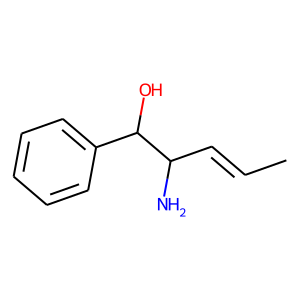

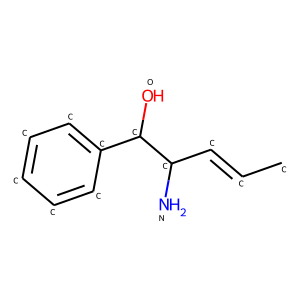

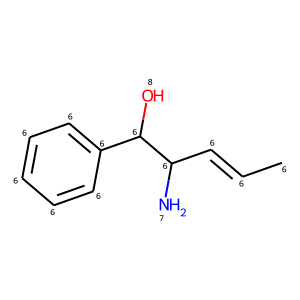

2. We can view the bonds of a molecule as an edge. These can be represented, like atoms, with a one-hot encoding, where a single bond would be given an encoding of 1, a double bond 2, an aromatic bond 3, and so on. This allows us to tune the importance of a given edge within a molecule:

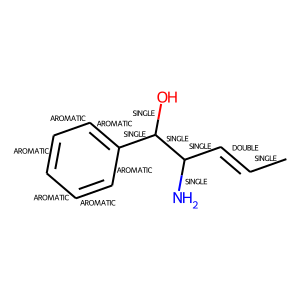

4. In order to get information from the protein impacting whether the ligand will bind, we can survey the surrounding neighborhood around each ligand atom. By performing a nearest-neighbor search around each atom, we collect the amino acid names of the protein and the distance to each amino acid. The amino acid names can also be one-hot encoded and the distances can be used to weigh their impact:

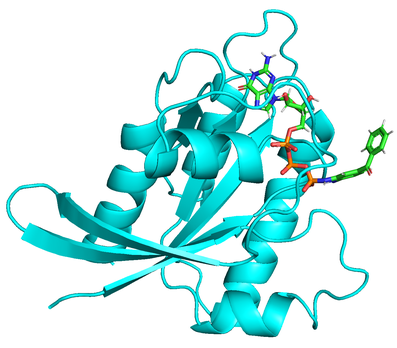

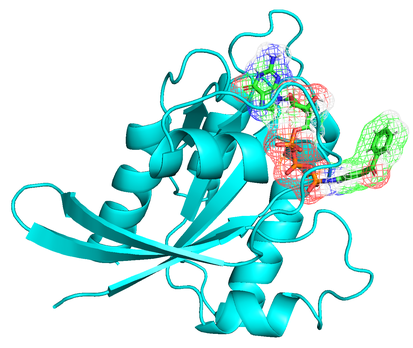

5. Finally, we can construct a multi-layered graph neural network. The main idea of graph neural networks is that we can generalize the convolution idea in images by supposing that an image can be represented as a highly regular graph. A convolution, in the graph sense, is then simply a convolution over the graphs neighborhood:

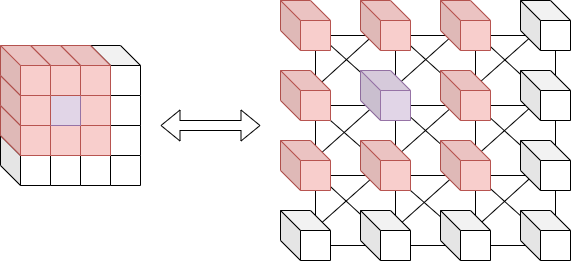

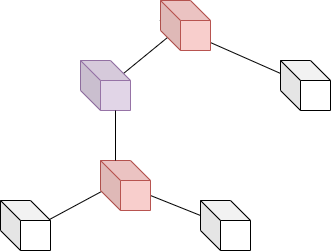


Putting everything together, we represent a each ligand in a protein-ligand complex as a graph. Its nodes represent **(1)** the atoomic number of each atom, **(2)** the distances to the nearest protein amino acid (residue), and **(3)** the name of the nearest protein residues. The edges represent the bond type of between each atom in the ligand. If no bond is present, neither is there an edge. Lastly, **(4)**, we hope to extract a global feature of the protein-ligand graph, the dissocivity constant, $k_\text{off}$.

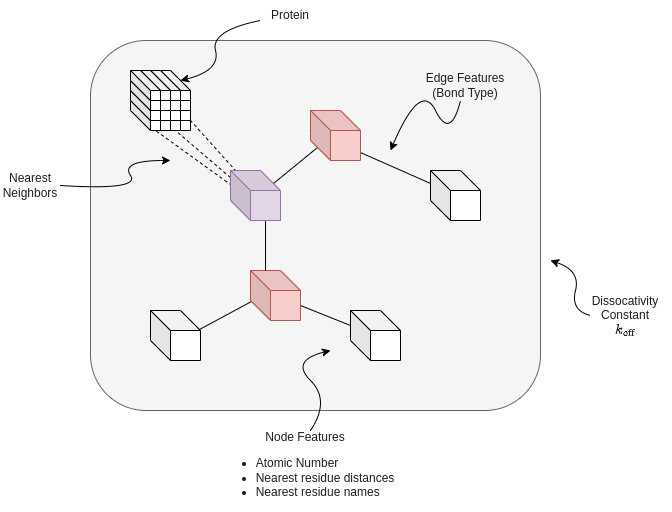

## Where to Find this Work
This notebook can be found under my GitHub Repository: https://github.com/benjamin-ahlbrecht/protein-ligand-dissociation-gnnhttps://github.com/benjamin-ahlbrecht/protein-ligand-dissociation-gnn.

# Setup and Packages
We begin by installing the necessary packages through the command line and importing them into our Python kernel.
- To work with Tensors and Neural Networks, we use tensorflow and spektral for GNNs
- NumPy and Pandas for data pre-processing
- BioPython and Rdkit for working with proteins and ligands, respectively
- Matplotlib for data visualization
- Scipy for querying nearest-neighbors

Additionally, we declare gloabl variables and hyper-parameters, setting the train, validation, and testing splits, the batch size of our neural network and the learning rate.

In [2]:
%%bash
# Install necessary Python packages
pip install spektral
pip install rdkit

# Create the directory which will contain our spektral dataset. DO NOT CHANGE
mkdir -p "/root/spektral/datasets/ProteinLigandDataset"

In [3]:
#-------------------------------------------------------------------------------#
# Arrays and linear algebra
import numpy as np

# Structured data
import pandas as pd

# OS I/O
import os
import sys

# Execution timing
from time import process_time

# G/TPU tensors and neural networks
import tensorflow as tf
from tensorflow import keras

import spektral
from spektral.transforms import NormalizeAdj

# Computational biology/chemistry
import Bio
from Bio import PDB
from Bio.PDB import PDBParser

from rdkit import Chem
import rdkit

# Visualization
from matplotlib import pyplot as plt

# Nearest-neighbor searching
from scipy.spatial import KDTree

# Jupyter settings
from IPython.core.display import HTML
np.set_printoptions(precision=3, linewidth=np.inf)

# Multi-processing and -threading
import concurrent.futures
from itertools import repeat

In [19]:
# Dataset directory
DATA_DIR = "../input/ligand-dissociation-prediction/koff_dataset"

# Data Splitting
TRAIN_VAL_PROPORTION = 0.9
TRAIN_PROPORTION = TRAIN_VAL_PROPORTION * 0.8
VAL_PROPORTION = TRAIN_VAL_PROPORTION * 0.2


# Model (Hyper)-Parameters
BATCH_SIZE = 16
EPOCHS = 500
LEARNING_RATE = 0.0001
EARLY_STOP_PATIENCE = 10

# Data Processing
Preprocessing our dataseet will require a number of individual steps. We attempt to abstract these steps away by separating everything into two classes:
1. The `DataReader()` class is utilized for interfacing with our raw unprocessed data, reading it in, and extracting the graphs. We normalize the $k_\text{off}$ value by taking the negative logarithm and z-score normalzing it afterwards. Taking the logarithm results in a strong normal distribution of values and z-score normalizing will help the neural network learn.
2. The `ProteinLigandDataset()` class allows the creation of `spektral.data.Dataset()` objects, which are necessary for graph learning. Spektral interfaces with Tensorflow and Keras such that, we can build Spektral layers directly on top of a `keras.Model` object.

In [5]:
class DataReader():
    def __init__(self, data_dir:str):
        """A data reader for processing the Koff Dataset. Reads the metadata and
        provides methods for reading ligands and proteins contain the data
        directory.
        
        Args:
          data_dir (str): The directory containing the koff_dataset
        """
        self.data_dir = data_dir
        self.structures_dir = os.path.join(self.data_dir, "initial_structure")
        self.metadata_fname = os.path.join(
            self.data_dir, "koff_index_cleaned.csv")
        self.metadata_full = pd.read_csv(self.metadata_fname)
        self.metadata = self.metadata_full[[
            "LIGAND_NAME", "K_OFF", "-LN(K_OFF)"]]
        
        # Normalize the log k_off
        self.mean = self.metadata["-LN(K_OFF)"].mean()
        self.std = self.metadata["-LN(K_OFF)"].std()
        self.metadata["-LN(K_OFF)"] = (
            (self.metadata["-LN(K_OFF)"] - self.mean) / self.std)
        
        
        # The PDBParser can be used to read any number of proteins from .pdb
        self.pdb_parser = PDBParser()
        
        # Create a dictionary of the metadata, so we can query it in O(1)
        ligand_names = self.metadata["LIGAND_NAME"]
        
        # Map bond types to integers (one-hot)
        self._bond_type_to_int = {
            "SINGLE": 1, "DOUBLE": 2, "TRIPLE": 3, "QUADRATIC": 4,"AROMATIC": 5}
        
        self._ligand_fname_to_log_koff = {
            ligand_name: koff for ligand_name, koff
            in zip(self.metadata["LIGAND_NAME"], self.metadata["-LN(K_OFF)"])}
        
    def bond_type_to_int(self, x:str):
        """Convert a bond type to an integer index.
        
        Args:
          x (str)
        Returns:
          index (int): The index for the given bond type
        """
        index = self._bond_type_to_int[x]
        return index
    
    @np.vectorize
    def _three_to_index(x:str):
        """Converts a byte-string of a 3-letter amino acid acronym to an integer
        index (one-hot)
        
        Args:
          x (str)
        Returns:
          index (int): The index of the amino acid
        """
        index = PDB.Polypeptide.three_to_index(x)
        return index
                
    def read_pdb(self, ligand_fname:str):
        """Read the associated protein in a .pdb file of a given ligand.
        
        Args:
          ligand_fname (str): The ligand file name associated with the protein
          to be queried. Ends with an extension: e.g., `.mol2`.
        Returns:
          protein (Bio.PDB.Structure.Structure): The protein structure
        """
        ligand_name, extension = os.path.splitext(ligand_fname)
        parent_dir = os.path.join(self.structures_dir, ligand_name)
        pdb_path = os.path.join(parent_dir, f"{ligand_name}_protein.pdb")
        
        protein = self.pdb_parser.get_structure(ligand_name, pdb_path)        
        return protein
    
    def read_ligand(self, ligand_fname:str):
        """Read the ligand in a .mol2 file
        
        Args:
          ligand_fname (str): The ligand file name to be queried.
        Returns:
          ligand (rdkit.Chem.Molecule): The ligand molecule
        """
        ligand_name, extension = os.path.splitext(ligand_fname)
        parent_dir = os.path.join(self.structures_dir, ligand_name)
        ligand_path = os.path.join(parent_dir, ligand_fname)
        
        ligand = Chem.MolFromMol2File(ligand_path)
        return ligand
    
    def _get_neighbor_residues(
        self,
        ligand:Chem.Mol,
        protein:Bio.PDB.Structure.Structure,
        n_neighbors:int=1,
        workers:int=1):
        """Extract the neighboring residues to each atom of a ligand. For full
        documentation on the nearest-neighbor process, see self.get_features().
        
        Args:
          ligand (rdkit.Chem.Mol)
          protein (Bio.PDB.Structure.Structure)
          workers (int)
        
        Returns:
          residue_distances (np.ndarray): The residue distances from each
            residue. Given the array A, A[i, j] denotes the distance of the
            (j+1)^th residue-nearest-neighbor for atom i in the ligand.
          residue_names_index (np.ndarray): The corresponding residue name of
            the residue_distances.
        """
        atom_pos = np.array([
            list(ligand.GetConformer().GetAtomPosition(i))
            for i in range(ligand.GetNumAtoms())])

        residue_pos = np.array([
            residue.center_of_mass() for residue in protein.get_residues()])
        residue_names = np.array([
            residue.get_resname() for residue in protein.get_residues()])
        
        # Query a KD-tree to find the 5 nearest residues to each ligand atom
        kd_tree = KDTree(residue_pos)
        residue_distances, residue_indices = kd_tree.query(
            x=atom_pos,
            k=n_neighbors,
            workers=workers)
        
        # Extract the name of each residue from the indices
        residue_names_nearest = residue_names[residue_indices]
        residue_names_index = self._three_to_index(residue_names_nearest)
        
        return (residue_distances, residue_names_index)

    def _get_neighborhood_residues(
        self,
        ligand:Chem.Mol,
        protein:Bio.PDB.Structure.Structure,
        radius:float=5.0,
        workers:int=1):
        """Extract all residues within a set neighborhood around each ligand
        atom. Instead of querying k-nearest-neighbors, it queries all neighbors
        within a circular radius around the atom.

        Args:
          ligand (rdkit.Chem.Mol)
          protein (Bio.PDB.Structure.Structure)
          radius (float): The specified radius to search for neigbhoring
            residues.
          workers (int)

        Returns:
          residue_name_indices (np.ndarray): The nearest residue indices
        """
        atom_pos = np.array([
            list(ligand.GetConformer().GetAtomPosition(i))
            for i in range(ligand.GetNumAtoms())])

        residue_pos = np.array([
            residue.center_of_mass() for residue in protein.get_residues()])
        residue_names = np.array([
            residue.get_resname() for residue in protein.get_residuees()])

        kd_tree = KDTree(residue_pos)
        residue_indices = kd_tree.query_ball_point(x=atom_pos, r=radius, p=2)

        residue_name_indices = residue_names[residue_indices]
        residue_name_indices = self._three_to_index(residue_name_indices)
        return residue_name_indices
        
    def _get_ligand_adjacency(self, ligand:Chem.Mol):
        """Extract the adjacency matrix for a given ligand. See
        self.get_features() for information on the adjacency matrix.
        
        Args:
          ligand (rdkit.Mol)
        Returns:
          adjacency (np.ndarray)
          edge_features (np.ndarray)
        """
        n = ligand.GetNumAtoms()
        adjacency = np.zeros((n, n), dtype=float)
        edge_features = np.zeros((n, n), dtype=float)
        
        for i, atom in enumerate(ligand.GetAtoms()):
            for atom_neighbor in atom.GetNeighbors():
                j = atom_neighbor.GetIdx()
                
                bond = ligand.GetBondBetweenAtoms(i, j)
                bond_type = str(bond.GetBondType())
                bond_type_index = self.bond_type_to_int(bond_type)
                
                adjacency[i, j] = 1
                edge_features[i, j] = bond_type_index
        
        return (adjacency, edge_features)
                
    
    def _get_ligand_atoms_names(self, ligand:Chem.Mol):
        """Extract the name (symbol) for each atom in a molecule. See
        self.get_features() for more information.
        
        Args:
          ligand (rdkit.Chem.Mol)
        Returns:
          atom_names (np.ndarray): The atom names in the form of a (n, 1) NumPy
            array, where the index of each row corresponds the atom index.
        """
        atom_names = np.array([
            atom.GetAtomicNum()
            for atom in ligand.GetAtoms()]).reshape(-1, 1)
        
        return atom_names
    
    def _get_protein_ligand_label(self, ligand_fname:str):
        """Extract the k_off values for a given protein-ligand complex. For more
        information, see the self.get_features().
        
        Args:
          ligand (str): The file name for 
        Returns:
          label (float): The k_off value corresponding to the protein-ligand
            complex.
        """
        label = self._ligand_fname_to_log_koff[ligand_fname]
        return label
    
    def get_features(
        self,
        ligand_fname:str,
        query_neighborhood:bool=False,
        n_neighbors:int=4,       
        workers:int=1):
        """Extract the adjacency matrix, node features, edge features, and
        labels for a given protein-ligand complex.
        
        The adjacency matrix, a, is given in dense form such that the first and
        second elements in a row represent a source and destination node with an
        edge between the two. The third element in a row represents the weight
        of their edge (a constant 1 for our cases).
        
        The node features matrix, x, contains a single row for each node, and a
        corresponding column for each feature. There are (1 + n_neighbors * 2)
        total node features. They are...
        (1) The ligand atom type (1 element in the feature vector)
        (2) The protein nearest neighbor distances (n_neighbors elements)
        (3) The protein nearest neighbor residue names (n_neighbors elements)
        
        The edge features matrix, e, is similar to the adjacency matrix. Instead
        of utilizing an edge weight, the edge features matrix instead provides
        an additional column for each feature in the edges. Here, we only have a
        single feature, the bond type (e.g., SINGLE, DOUBLE, TRIPLE, ...).
        
        The label, y, provides a value for the protein-ligand complex which we
        are trying to predict. The label here is the off- or dissociation-rate
        constant, `k_off`. A smaller `k_off` constant indicates that the ligand
        is more tightly bound to its protein.
        
        Args:
          ligand_fname (str): The ligand file name. We will extract both the
            protein and the associated ligand.
          query_neighborhood (bool): Whether to query for residues in a 5
            Angrstrom neighborhood around the molecule rather than query k-
            nearest neighbors.
          n_neighbors (int): The number of nearest-protein-neighbors to query
            for each atom in the ligand.
          workers (int): The number of parallel calls to make to the KD-tree
            when querying nearest neighbors. A value of -1 maximizes the number
            of workers utilized.
        
        Returns:
          a (np.ndarray): The adjacency matrix (list)
          e (np.ndarray): The edge feature adjacency matrix (list)
          x (np.ndarray): The edge features matrix
          y (np.ndarray): The label vector
        """
        ligand = self.read_ligand(ligand_fname)
        protein = self.read_pdb(ligand_fname)
        
        atom_names = self._get_ligand_atoms_names(ligand)
        
        if query_neighborhood:
            neighbors = self._get_neighborhood_residues(
                ligand,
                protein,
                radius=5.0,
                workers=workers)
            x = np.column_stack((atom_names, neighbors))
        else:
            distances, names = self._get_neighbor_residues(
                ligand,
                protein,
                n_neighbors=n_neighbors,
                workers=workers)
            x = np.column_stack((atom_names, distances, names))
        
        a, e = self._get_ligand_adjacency(ligand)
        y = self._get_protein_ligand_label(ligand_fname)
        return (a, x, e, y)

In [6]:
class ProteinLigandDataset(spektral.data.Dataset):
    def __init__(self, data_dir:str, **kwargs):
        """Create a spektral dataset for the protein-ligand data
        """
        super().__init__(**kwargs)
        print(f"Spectral Dataset Path: {self.path}")
    
    def download_file(
        self,
        outname:str,
        a:np.ndarray,
        x:np.ndarray,
        e:np.ndarray,
        y:np.ndarray):
        """Download a file given a graph.
        
        Args:
          outname (str): The output file name the .npz file
          a (np.ndarray): The adjacency matrix
          x (np.ndarray): The node features matrix
          e (np.ndarray): The edge features matrix
          y (np.ndarray): The label vector (Potentially a NumPy scalar)
        """
        fname = os.path.join(self.path, outname)
        np.savez(fname, a=a, x=x, e=e, y=y)
        
    def download_file_from_ligand_fname(
        self,
        ligand_fname:str,
        data_reader:DataReader):
        """Process a single protein-ligand complex from a ligand file name and 
        download it onto the spektral dataset path.
        
        Args:
          ligand_fname (str): The file name of the protein-ligand complex we wish
            to process and download.
          data_reader (DataReader): The protein-ligand complex data reader

        """
        a, x, e, y = data_reader.get_features(ligand_fname)
        outname, extension = os.path.splitext(ligand_fname)
        self.download_file(outname=outname, a=a, x=x, e=e, y=y)
        
    def download_files_from_data_reader(
        self,
        data_reader:DataReader,
        query_neighborhood:bool=False):
        """Process all protein-ligand complexes contained in the data reader.
        
        Args:
          data_reader (DataReader): The protein-ligand complex data reader
          query_neighborhood (bool): Whether to query a 5 Angstrom
            neighborhood rather than k-nearest neighbors.
        """
        fnames = data_reader.metadata["LIGAND_NAME"]
        
        if query_neighborhood:
            with concurrent.futures.ProcessPoolExecutor() as executor:
                executor.map(
                    self.download_file_from_ligand_fname,
                    fnames,
                    repeat(data_reader),
                    repeat(True)
                )
        else:
            with concurrent.futures.ProcessPoolExecutor() as executor:
                executor.map(
                    self.download_file_from_ligand_fname,
                    fnames,
                    repeat(data_reader)
                )
        
    def read(self):
        fnames = (
            os.path.join(self.path, fname)
            for fname in os.listdir(self.path)
            if fname.endswith(".npz"))
        
        output = []
        for fname in fnames:
            data = np.load(fname)
            graph = spektral.data.Graph(
                x=data["x"],
                a=data["a"],
                y=data["y"])
            output.append(graph)
        
        return output

In [7]:
data_reader = DataReader(DATA_DIR)
data_reader.metadata.head(20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,LIGAND_NAME,K_OFF,-LN(K_OFF)
0,3hec_ligand_native_1.mol2,0.380000,-1.087683
1,3heg_ligand_native_2.mol2,0.018000,-0.169185
2,1kv2_ligand_native_3.mol2,0.000008,2.144341
3,1kv1_ligand_native_4.mol2,0.062000,-0.541657
4,3gcq_ligand_native_5.mol2,0.036848,-0.384948
5,3gcv_ligand_native_6.mol2,0.009739,0.015787
6,3d83_ligand_native_10.mol2,0.008400,0.060347
7,3d7z_ligand_native_11.mol2,0.023000,-0.243007
8,3gcp_ligand_native_12.mol2,0.016000,-0.133712
9,2yiw_ligand_native_16.mol2,0.000040,1.670719


In [8]:
dataset = ProteinLigandDataset(DATA_DIR)
dataset.download_files_from_data_reader(data_reader)

Spectral Dataset Path: /root/spektral/datasets/ProteinLigandDataset


/opt/conda/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5825
  PDBConstructionWarning,
[20:36:09] 4mzn_ligand_native_34.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[20:36:09] 5jt9_ligand_native_35.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[20:36:09] 5js3_ligand_native_36.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[20:36:09] 5jvi_ligand_native_37.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[20:36:09] 5jss_ligand_native_38.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[20:36:09] 5lwd_ligand_1_39_dock.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[20:36:09] 5lwd_ligand_2_40_dock.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[20:36:09] 5lwd_ligand_3_41_dock.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[20:36:09] 5lwd_ligand_4_42_dock.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[20:36:09] 5lif_ligand_native_43.mol2: warning - O.co2 with non

In [9]:
dataset = ProteinLigandDataset(DATA_DIR)

Spectral Dataset Path: /root/spektral/datasets/ProteinLigandDataset


# Data Exploration
To examine our data, we can look at the distribution of our dissocitavity constant, $k_\text{off}$. By taking the logarithm, we can see how the distribution becomes more discernable and has a strong normal distribution. we also examine the adjacency matrix of some ligands. A black pixel at `[i, j]` means the there exists an edge from atom with index `i` to atom with index `j`. Through this, we can see how some ligands are quite linear with some small side chains and other have a number of side chains and cyclic motifs.

Text(0.5, 0, 'k_off')

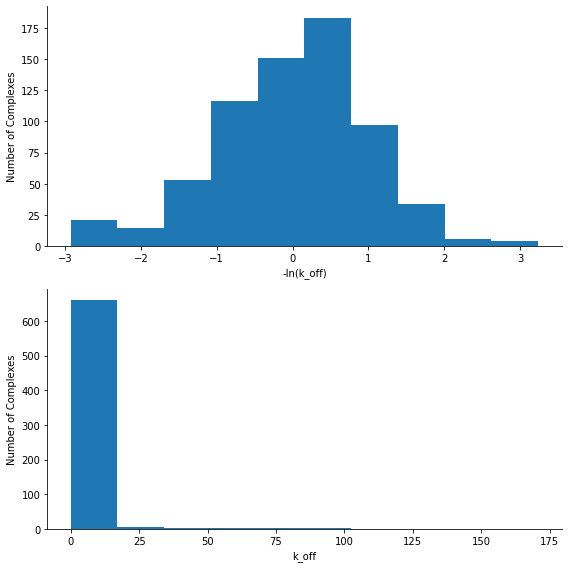

In [10]:
k_off = data_reader.metadata["K_OFF"]
log_k_off = data_reader.metadata["-LN(K_OFF)"]
fig, ax = plt.subplots(nrows=2, figsize=(8, 8), tight_layout=True)

ax[0].hist(log_k_off)
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].set_ylabel("Number of Complexes")
ax[0].set_xlabel("-ln(k_off)")

ax[1].hist(k_off)
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].set_ylabel("Number of Complexes")
ax[1].set_xlabel("k_off")

Text(0, 0.5, 'Frequency')

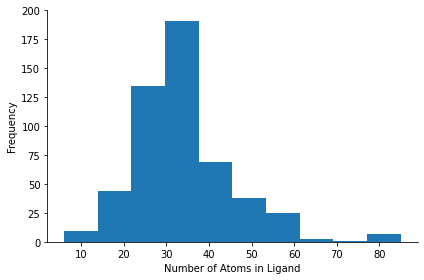

In [11]:
n_atoms = [d.n_nodes for d in dataset]

fig, ax = plt.subplots(tight_layout=True)
ax.hist(n_atoms)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Number of Atoms in Ligand")
ax.set_ylabel("Frequency")

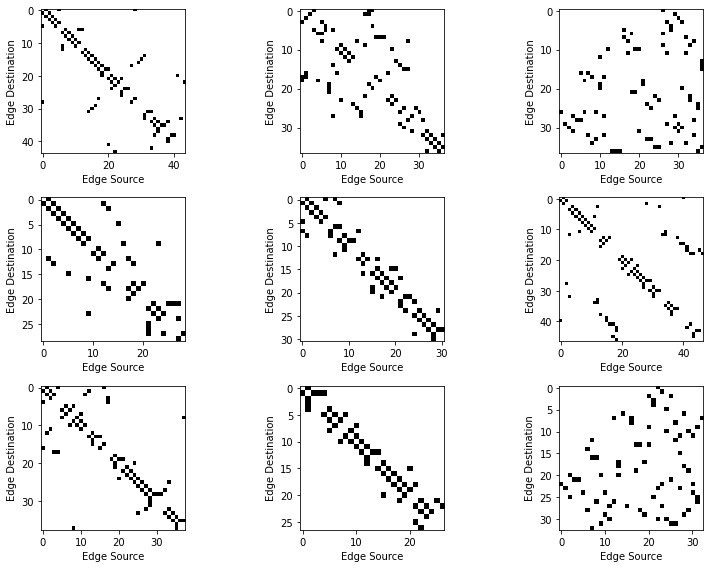

In [12]:

sqrt_n = 3

fig, ax = plt.subplots(nrows=sqrt_n, ncols=sqrt_n, figsize=(13, 8), tight_layout=True)
k = 0
for i in range(sqrt_n):
    for j in range(sqrt_n):
        adjacency = dataset[k].a
        ax[i, j].imshow(adjacency, cmap="binary")
        ax[i, j].set_xlabel("Edge Source")
        ax[i, j].set_ylabel("Edge Destination")
        
        k += 1

# Creating Training, Validation, and Testing Datasets
As with many machine-learning tasks, we split our data into training, validation, and testing sets. The test dataset is 10% of the total data, while the training set is 80% of the remaining 90% and the validation set is 20% of the remaining 90%. These hyper-parameters are defined at the start.

Data loaders are created to streamline feeding data into the neural network. This uses spektral's `spektral.data.DisjointLoader()` class which combines all graphs into a single graph via their disjoint union. Essentially, it provides the nodes within each graph their individual index such that no graphs overlap:

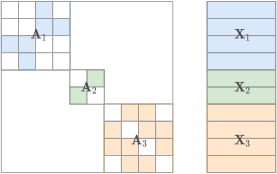

In [13]:
# Extract training, testing, and validation data
n_graphs = len(dataset)

train_size = int(n_graphs * TRAIN_PROPORTION)
val_size = int(n_graphs * VAL_PROPORTION)

data_train = dataset[0:train_size]
data_val = dataset[train_size:train_size+val_size]
data_test = dataset[train_size+val_size:]

print(f"""\
Graph Size: {n_graphs}
Train Size: {len(data_train)}
Val Size:   {len(data_val)}
Test Size:  {len(data_test)}\
""")

Graph Size: 521
Train Size: 375
Val Size:   93
Test Size:  53


In [22]:
# Define loaders for getting batches of graphs
data_train_loader = spektral.data.DisjointLoader(
    data_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS)

data_val_loader = spektral.data.DisjointLoader(
    data_val,
    batch_size=BATCH_SIZE)

data_test_loader = spektral.data.DisjointLoader(
    data_test,
    batch_size=BATCH_SIZE)

# Model Building
Here, we define our graph neural network. We utilize 2 graphs convolutional layers with a Leaky ReLU activation. A global average pool follows to reduce the cardinality of our intermediate graphs. With these, we utilize a single dense layer. A linear activation is utilized in the last layer since we can predict an real-valued number. Thus, it would be innapropriate to utilize a Tanh or Sigmoid. Since our data is normally distributed and centered around 0, a leaky ReLU would unfavorable weigh positive values. Thus, all previous layers are trained to predict the final output layer.

In [23]:
class GNN(keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = spektral.layers.GCSConv(32, activation="leaky_relu")
        self.conv2 = spektral.layers.GCSConv(32, activation="leaky_relu")
        self.global_pool = spektral.layers.GlobalAvgPool()
        self.dense = keras.layers.Dense(1, activation=None)
        
    def call(self, inputs):
        x, a, i = inputs
        
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.global_pool([x, i])
        output = self.dense(x)
        return output

In [24]:
model = GNN()
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_function = keras.losses.MeanSquaredError()

In [25]:
@tf.function(input_signature=data_train_loader.tf_signature(),
             experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_function(target, predictions) + sum(model.losses)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def evaluate(loader:spektral.data.Loader):
    output = []
    step = 0
    
    while step < loader.steps_per_epoch:
        step += 1
        
        inputs, target = next(loader)
        predictions = model(inputs, training=False)
        
        loss = loss_function(target, predictions)
        loss_average = np.mean(loss)
        output.append(loss_average)
    
    output = np.mean(output)
    return output

# Model Training and Validation
We create a custom fit function for training the GNN. At each step, it computes the training and validation losses of the mean-squared error function and updates the weights accordingly. We plot the training history to show how the GNN trains over time.

In [26]:
epoch = 0
step = 0

best_val_loss = np.inf
best_weights = None

patience = EARLY_STOP_PATIENCE
results = []
epoch_loss = []
epoch_val_loss = []

for batch in data_train_loader:
    step += 1
    loss = train_step(*batch)
    results.append(loss)
    
    if step == data_train_loader.steps_per_epoch:
        step = 0
        epoch += 1
        
        val_loss = evaluate(data_val_loader)
        print(f"Epoch: {epoch} - Loss:{np.mean(results)} - Val Loss: {val_loss}")
        epoch_loss.append(np.mean(results))
        epoch_val_loss.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = EARLY_STOP_PATIENCE
            best_weights = model.get_weights()
        else:
            patience -= 1
            if patience == 0:
                print(f"Early Stopping (Best Val Loss: {best_val_loss})")
                break
        
        results = []

Epoch: 1 - Loss:104.90814208984375 - Val Loss: 21.28896141052246
Epoch: 2 - Loss:9.629042625427246 - Val Loss: 7.130220890045166
Epoch: 3 - Loss:6.180710315704346 - Val Loss: 6.284395217895508
Epoch: 4 - Loss:5.576230525970459 - Val Loss: 5.844441890716553
Epoch: 5 - Loss:5.3754353523254395 - Val Loss: 5.804262638092041
Epoch: 6 - Loss:5.213088512420654 - Val Loss: 5.625194549560547
Epoch: 7 - Loss:5.060600757598877 - Val Loss: 5.441962718963623
Epoch: 8 - Loss:4.8982110023498535 - Val Loss: 5.232898235321045
Epoch: 9 - Loss:4.696996688842773 - Val Loss: 5.154311656951904
Epoch: 10 - Loss:4.55585241317749 - Val Loss: 5.028539657592773
Epoch: 11 - Loss:4.487135410308838 - Val Loss: 4.8289265632629395
Epoch: 12 - Loss:4.40974760055542 - Val Loss: 4.7038655281066895
Epoch: 13 - Loss:4.177591323852539 - Val Loss: 4.525552272796631
Epoch: 14 - Loss:4.163215637207031 - Val Loss: 4.371201992034912
Epoch: 15 - Loss:3.9674909114837646 - Val Loss: 4.218719005584717
Epoch: 16 - Loss:3.85741543769

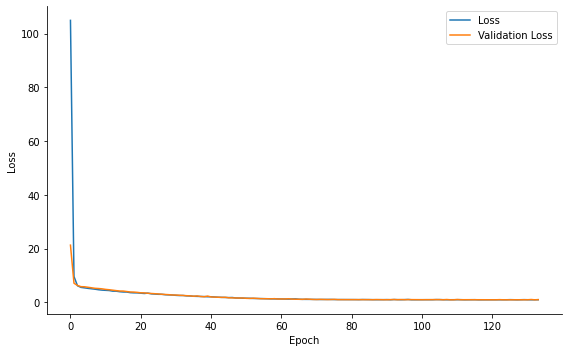

In [27]:
loss = np.array(epoch_loss)[:-EARLY_STOP_PATIENCE+1]
val_loss = np.array(epoch_val_loss)[:-EARLY_STOP_PATIENCE+1]

fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(loss, label="Loss")
ax.plot(val_loss, label="Validation Loss")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

# Model Testing
We can find the MSE of the testing data by simply calling our model. We compute the MSE loss and plot the residuals for each batch to examine if there are any outliers skewing the results

In [54]:
test_predictions = []
test_truth = []

for step, batch in enumerate(data_test_loader):
    if step >= data_test_loader.steps_per_epoch:
        break
        
    inputs, targets = batch
    predictions = model(inputs)
    
    for prediction, target in zip(predictions, targets):
        test_predictions.append(prediction)
        test_truth.append(target)
    

In [59]:
test_predictions = np.array(test_predictions)
test_truth = np.array(test_truth)

Text(-2.0, 1.5, 'MSE = 0.681')

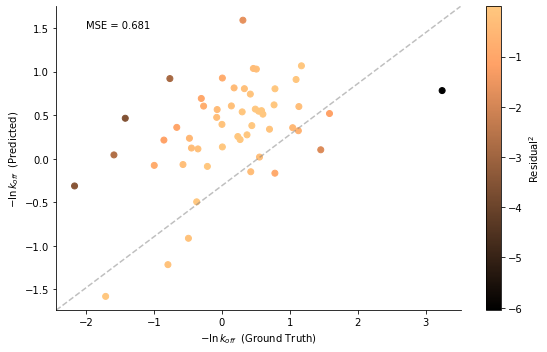

In [104]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
s = ax.scatter(x=test_truth, y=test_predictions, c=-(test_predictions - test_truth)**2, cmap="copper")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="gray", ls="--", alpha=0.5)
ax.set_xlabel("$-\ln k_{off}$  (Ground Truth)")
ax.set_ylabel("$-\ln k_{off}$  (Predicted)")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.colorbar(s, label="Residual$^2$")
ax.text(x=-2.0, y=1.5, s=f"MSE = {np.mean((test_predictions - test_truth)**2).round(3)}")

# Conclusion and Future Work
While the graph neural network appears to capture the general linear trend of dissocivity constant, it has a slight positive bias and struggles to correctly estimate some constants that stray far from the mean. There are a number of potential ways we could attempt to refine our estimations:
1. More rigorous hyperparameter tuning could help predict the outliers in our truth Vs. predicted plot.
2. A dual graph-neural network could directly integrate information from both the protein and the ligand in the protein-ligand complex. The current method integrates nearest-neighbor information from the protein into each ligand feature node. This could help us utilize non-local information from the protein that may impact binding.